Valid : https://github.com/IndoNLP/indonlu/blob/master/dataset/smsa_doc-sentiment-prosa/valid_preprocess.tsv

test : https://github.com/IndoNLP/indonlu/blob/master/dataset/smsa_doc-sentiment-prosa/test_preprocess.tsv

In [1]:
import pandas as pd
import numpy as np
import re
import pickle
from collections import defaultdict
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten, SimpleRNN, Activation, Bidirectional
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score

!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import time



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.2 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
model_lstm = load_model('/content/drive/MyDrive/Colab Notebooks/Binar-Academy/model/LSTM/LSTM2106.h5')

tokenizer = Tokenizer(num_words=100_000, lower=True, split=' ')
sentiment = ['negative', 'neutral', 'positive']

file = open('/content/drive/MyDrive/Colab Notebooks/Binar-Academy/model/LSTM/X_pad_sequances.pickle','rb')
feature_lstm = pickle.load(file)
file.close()


input_text = 'Saya suka makan padang'
input_text = [text_proses(input_text)]

feature = tokenizer.texts_to_sequences(input_text)
feature = pad_sequences(feature, maxlen = feature_lstm.shape[1])

prediction = model_lstm.predict(feature)
get_sentiment = sentiment[np.argmax(prediction[0])]
print(input_text)
print(get_sentiment)

1/1 [==============================] - 0s 391ms/step
['saya suka makan padang']
positive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Binar-Academy/data/data_bersih_update.csv')

In [ ]:
df.head()

,text,label,pro_text_no_angka,no_stopwords
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini milik oleh usaha pabrik tahu yang s...,warung milik usaha pabrik puluh kenal putih ba...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k mmbri hujjah partai...,mohon ulama lurus k mmbri hujjah partai diwlh ...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatra bandung temp...,lokasi strategis jalan sumatra bandung nya nya...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...,betapa bahagia nya unboxing paket barang nya b...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,aduh jadi mahasiswa jangan sombong dong kasih ...,aduh mahasiswa sombong kasih kartu kuning ajar...


In [5]:
# Fungsi untuk membagi data menjadi data train, test & validation

def train_test_val_split_imbalanced(X, y, train_percent, test_percent, val_percent, random_state=42):
    # Split the data into training and temporary set while preserving class proportions
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_percent), random_state=random_state, stratify=y)

    # Calculate the percentage of remaining data for validation and testing
    remaining_percent = 1 - train_percent
    val_percent_relative = val_percent / remaining_percent
    test_percent_relative = test_percent / remaining_percent

    # Split the temporary set into testing and validation sets while preserving class proportions
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=test_percent_relative, random_state=random_state, stratify=y_temp)

    return X_train, X_test, X_val, y_train, y_test, y_val



# Assuming 'df' is your DataFrame with 'text' and 'label' columns
X = df['pro_text_no_angka']
y = df['label']

# Split the imbalanced data into train, test, and validation sets
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split_imbalanced(X, y, 0.6, 0.2, 0.2)

# Print the sizes of the resulting sets
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))
print("Validation set size:", len(X_val))



Train set size: 6600
Test set size: 2200
Validation set size: 2200


In [ ]:
y_train.value_counts(), y_val.value_counts(), y_test.value_counts()

(positive    3850
 negative    2061
 neutral      689
 Name: label, dtype: int64,
 positive    1283
 negative     688
 neutral      229
 Name: label, dtype: int64,
 positive    1283
 negative     687
 neutral      230
 Name: label, dtype: int64)

In [6]:


kamus_alay = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Binar-Academy/data/new_kamusalay.csv', encoding='Latin-1',names=('alay','baku'))

# Melakukan Cleaning tweet tanpa menghapus stopwords
def text_proses(text):

    # Untuk stemmer kata
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    if type(text) == np.float64:
        return ""
    temp = re.sub(r'\b(USER|RT|URL)\b', '', text)
    temp = temp.lower()
    temp = re.sub(r"@[A-Za-z0-9_]+","", temp) #Menghilangkan Mention
    temp = re.sub("#[A-Za-z0-9_]+","", temp) #Menghilangkan Hashtag
    temp = re.sub(r'https://\S+', '', temp)
    # Melakukan subtitusi kata alay dengan kata baku
    temps = temp.split()
    for i in range(len(temps)):
        temp = temps[i]
        replacement = kamus_alay[kamus_alay['alay'] == temp]['baku']
        if not replacement.empty:
            temps[i] = replacement.iloc[0]
    temp = " ".join(temp.strip() for temp in temps)

    # # Mengubah angka menjadi terbaca
    # temps = temp.split()
    # for i in range(len(temps)):
    #     temp = temps[i]
    #     if temps[i].isdigit() == True :
    #         temps[i] = Terbilang().parse(temps[i]).getresult()
    #     else :
    #         temps[i]
    # temp = " ".join(temp.strip() for temp in temps)

    # Melakukan stemming
    tokens = word_tokenize(temp)
    temp = ' '.join([word for word in tokens ])
    temp = stemmer.stem(temp)

    temp = re.sub(r'\\x..', '', temp) #Menghilangkan Emoticon
    temp = re.sub(r'&amp;', 'dan', temp)
    temp = re.sub(r'http\S+', '', temp) #Menghilangkan link
    temp = re.sub(r"www.\S+", "", temp) #Menghilangkan link
    temp = re.sub(r"\\[n|t]", "", temp) #Menghilangkan 'enter' dan 'tab'
    temp = re.sub("[^A-Za-z\s']","", temp) #Menghilangkan yang bukan huruf
    temps = temp.split()
    temp = " ".join(temp.strip() for temp in temps)

    return temp



In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Binar-Academy/data/data_bersih_no_angka.csv')
df.head()

,text,label,pro_text_no_angka
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini milik oleh usaha pabrik tahu yang s...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k mmbri hujjah partai...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatra bandung temp...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,aduh jadi mahasiswa jangan sombong dong kasih ...


In [ ]:
# neg = df.loc[df.label == 'negative'].pro_text_no_angka.to_list()
# neu = df.loc[df.label == 'neutral'].pro_text_no_angka.to_list()
# pos = df.loc[df.label == 'positive'].pro_text_no_angka.to_list()
X_train_list = X_train.to_list()
X_val_list = X_val.to_list()
X_test_list = X_test.to_list()

# neg_label = df.loc[df.label == 'negative'].label.to_list()
# neu_label = df.loc[df.label == 'neutral'].label.to_list()
# pos_label = df.loc[df.label == 'positive'].label.to_list()
y_train_list = y_train.to_list()
y_val_list = y_val.to_list()
y_test_list = y_test.to_list()

In [ ]:
# total_data = neg + neu + pos
# labels = neg_label + neu_label + pos_label

# print('Pos : %s, Neu : %s, Neg : %s' %(len(pos), len(neu),len(neg)))
# print("Total data : %s" %len(total_data))

Pos : 6416, Neu : 1148, Neg : 3436
Total data : 11000


In [ ]:
max_features = 100_000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(X_train_list)

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('tokenizer.pickle has created!!!')

# Memanggil modul tokenizer
X_train_token = tokenizer.texts_to_sequences(X_train_list)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X_train_token)

# Memanggil modul pad sequances
X_train_padded = pad_sequences(X_train_token)

with open('X_pad_sequances.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('X_pad_sequances.pickle has created!!!')



tokenizer.pickle has created!!!
X_pad_sequances.pickle has created!!!


In [ ]:
# Menyimpan variable Y ke format pickle
Y_train_dummies = pd.get_dummies(y_train_list)
Y_train_dummies = Y_train_dummies.values

with open('y_labels.pickle','wb') as handle:
    pickle.dump(Y_train_dummies,handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('y_labels.pickle has created!!')

y_labels.pickle has created!!


In [ ]:
# # melakukan split train test

# file = open('X_pad_sequances.pickle','rb')
# X = pickle.load(file)
# file.close()

# file = open('y_labels.pickle','rb')
# Y = pickle.load(file)
# file.close()

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1,stratify=Y)

## Menggunakan SimpleRNN

In [ ]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length= X.shape[1]))
model.add(SimpleRNN(units, dropout=0.2))
model.add(Dense(3, activation='softmax'))
sgd = optimizers.legacy.Adam(learning_rate=0.001)
model.compile(loss = 'category_crossentropy', optimizer='adam', metrics= ['accuracy'])
print(model.summary())

adam = optimizers.legacy.Adam(learning_rate=0.001)
model.compile(loss = 'category_crossentropy', optimizer='adam', metrics= ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs = 10, batch_size=10, validation_data=(X_test,y_test), verbose=1, callbacks=[es])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 85, 100)           10000000  
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                10560     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10,010,755
Trainable params: 10,010,755
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
880/880 [==============================] - 114s 123ms/step - loss: 0.3463 - accuracy: 0.7789 - val_loss: 0.2750 - val_accuracy: 0.8441
Epoch 2/10
880/880 [==============================] - 92s 104ms/step - loss: 0.1997 - accuracy: 0.8875 - val_loss: 0.2676 - val_accuracy: 0.8468
Epoch 3/10
8

In [ ]:
predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('Testing selesai !')
print(matrix_test)

69/69 [==============================] - 1s 8ms/step
Testing selesai !
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       687
           1       0.75      0.77      0.76       230
           2       0.91      0.87      0.89      1283

    accuracy                           0.84      2200
   macro avg       0.80      0.82      0.81      2200
weighted avg       0.85      0.84      0.84      2200



### Cross Validation

In [ ]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

accuracies = []
y = Y
embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):
    data_train = X[data[0]]
    target_train = y[data[0]]

    data_test = X[data[1]]
    target_test = y[data[1]]

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length= X.shape[1]))
    model.add(SimpleRNN(units, dropout=0.2))
    model.add(Dense(3, activation='softmax'))
    sgd = optimizers.legacy.Adam(learning_rate=0.001)
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

    adam = optimizers.legacy.Adam(learning_rate=0.001)
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    history = model.fit(X_train, y_train, epochs = 10, batch_size=10, validation_data=(X_test,y_test), verbose=1, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print('='*50)

    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)

print()
print("Rata-rata Accuracy : ", average_accuracy)

Epoch 1/10
880/880 [==============================] - 99s 111ms/step - loss: 0.3744 - accuracy: 0.7423 - val_loss: 0.2763 - val_accuracy: 0.8427
Epoch 2/10
880/880 [==============================] - 82s 93ms/step - loss: 0.2154 - accuracy: 0.8767 - val_loss: 0.3069 - val_accuracy: 0.8214
Epoch 2: early stopping
69/69 [==============================] - 1s 8ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.80      0.68      0.74       687
           1       0.65      0.75      0.70       230
           2       0.86      0.91      0.88      1283

    accuracy                           0.82      2200
   macro avg       0.77      0.78      0.77      2200
weighted avg       0.82      0.82      0.82      2200

Epoch 1/10
880/880 [==============================] - 100s 112ms/step - loss: 0.4049 - accuracy: 0.7084 - val_loss: 0.3329 - val_accuracy: 0.7791
Epoch 2/10
880/880 [==============================] - 82s 93ms/step - loss: 0.2298 - accurac

### Melakukan plot history

Untuk melihat perbandingan antara Acc Vs Validation Acc **dan** Loss Vs Validation Loss

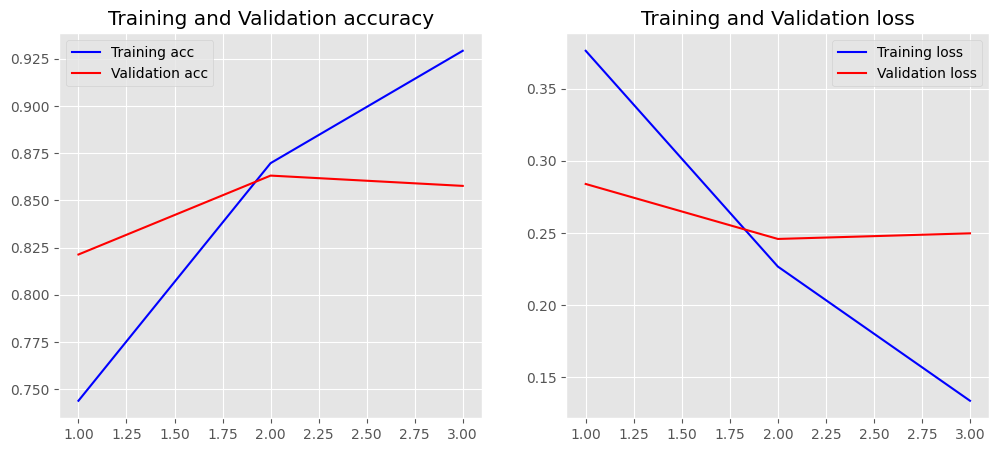

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc)+1)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and Validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [ ]:
# Save model
model.save('SimpleRNN.h5')
print("Model has created !!! ")

Model has created !!! 


In [ ]:
# Melakukan test real world
input_text = """


     Kalo belom nonton Kartini harus banget sih nonton     ! Sama film korea     judulnya   Obsessed tp 18+++ huehe ()



"""

In [ ]:
text_proses(input_text)

'kalau belum tonton kartini harus banget sih tonton sama film korea judul obsessed tetapi huehe'

In [ ]:
sentiment = ['negative', 'neutral', 'positive']

text = [text_proses(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('SimpleRNN.h5')
predictions = model.predict(guess)
polarity = np.argmax(predictions[0])

print("Text :", text[0])
print("Sentiment :", sentiment[polarity])

1/1 [==============================] - 0s 150ms/step
Text : kalau belum tonton kartini harus banget sih tonton sama film korea judul obsessed tetapi huehe
Sentiment : negative


## Menggunakan LSTM

In [ ]:
# melakukan split train test

file = open('X_pad_sequances.pickle','rb')
X = pickle.load(file)
file.close()

file = open('y_labels.pickle','rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1,stratify=Y)

In [ ]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length= X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics= ['accuracy'])
print(model.summary())

adam = optimizers.legacy.Adam(learning_rate=0.00001)
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs = 20, batch_size=10, validation_data=(X_test,y_test), verbose=1, callbacks=[es])



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 85, 100)           10000000  
                                                                 
 lstm_2 (LSTM)               (None, 64)                42240     
                                                                 
 dense_8 (Dense)             (None, 3)                 195       
                                                                 
Total params: 10,042,435
Trainable params: 10,042,435
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
880/880 [==============================] - 32s 34ms/step - loss: 0.3104 - accuracy: 0.7998 - val_loss: 0.2149 - val_accuracy: 0.8745
Epoch 2/20
880/880 [==============================] - 11s 12ms/step - loss: 0.1573 - accuracy: 0.9133 - val_loss: 0.2077 - val_accuracy: 0.8868
Epoch 3/20
88

In [ ]:
predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('Testing selesai !')
print(matrix_test)

69/69 [==============================] - 1s 4ms/step
Testing selesai !
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       687
           1       0.82      0.66      0.73       230
           2       0.93      0.89      0.91      1283

    accuracy                           0.87      2200
   macro avg       0.84      0.81      0.82      2200
weighted avg       0.87      0.87      0.87      2200



### Cross Validation

In [ ]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

accuracies = []
y = Y
embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):
    data_train = X[data[0]]
    target_train = y[data[0]]

    data_test = X[data[1]]
    target_test = y[data[1]]

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length= X.shape[1]))
    model.add(LSTM(units, dropout=0.2))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

    adam = optimizers.legacy.Adam(learning_rate=0.001)
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    history = model.fit(X_train, y_train, epochs = 10, batch_size=10, validation_data=(X_test,y_test), verbose=1, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print('='*50)

    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)

print()
print("Rata-rata Accuracy : ", average_accuracy)

Epoch 1/10
874/874 [==============================] - 32s 35ms/step - loss: 0.2898 - accuracy: 0.8149 - val_loss: 0.2187 - val_accuracy: 0.8696
Epoch 2/10
874/874 [==============================] - 11s 12ms/step - loss: 0.1467 - accuracy: 0.9188 - val_loss: 0.2055 - val_accuracy: 0.8751
Epoch 3/10
874/874 [==============================] - 8s 10ms/step - loss: 0.0960 - accuracy: 0.9482 - val_loss: 0.2387 - val_accuracy: 0.8618
Epoch 3: early stopping
69/69 [==============================] - 1s 4ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       681
           1       0.84      0.69      0.76       258
           2       0.92      0.89      0.90      1246

    accuracy                           0.86      2185
   macro avg       0.85      0.82      0.83      2185
weighted avg       0.87      0.86      0.86      2185

Epoch 1/10
874/874 [==============================] - 33s 35ms/step - loss: 0.2954 - accuracy: 0

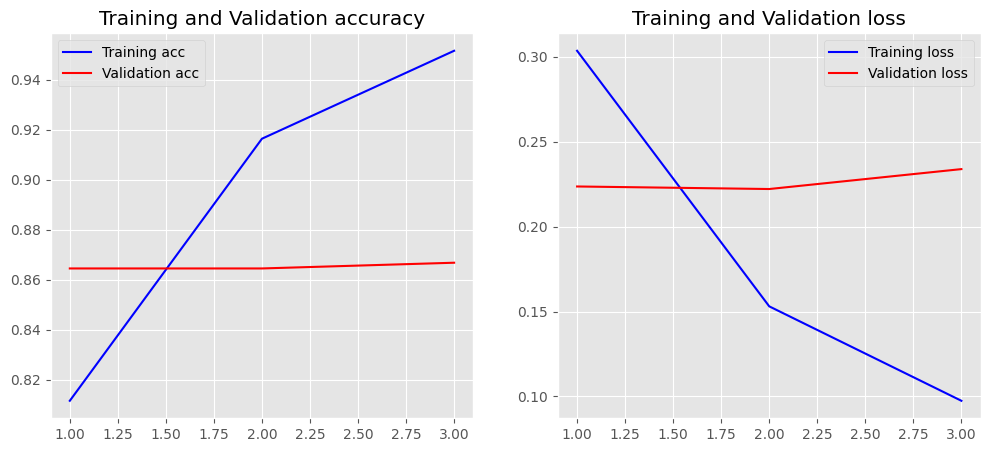

In [ ]:
# Melakukan visualisasi Accuracy vs Validation_accuracy
plot_history(history)

In [ ]:
model.save('LSTM.h5')
print('Model LSTM has created !!!')

Model LSTM has created !!!


In [ ]:
# Melakukan test real world
input_text = """

<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan Produk Bangsa Sendiri <PROVIDER_NAME>

"""

In [ ]:
# Melakukan test real world
input_text = """

Asiknya nonton Hitam Putih Trans7

"""

sentiment = ['negative', 'neutral', 'positive']

text = [text_proses(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('LSTM.h5')
predictions = model.predict(guess)
polarity = np.argmax(predictions[0])

print("Text :", text[0])
print("Sentiment :", sentiment[polarity])

1/1 [==============================] - 0s 347ms/step
Text : asiknya tonton hitam putih trans
Sentiment : neutral


## coba dengan data +stopwords

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Binar-Academy/data/data_bersih_update.csv')
df.head()

,text,label,pro_text_no_angka,no_stopwords
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini milik oleh usaha pabrik tahu yang s...,warung milik usaha pabrik puluh kenal putih ba...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k mmbri hujjah partai...,mohon ulama lurus k mmbri hujjah partai diwlh ...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatra bandung temp...,lokasi strategis jalan sumatra bandung nya nya...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...,betapa bahagia nya unboxing paket barang nya b...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,aduh jadi mahasiswa jangan sombong dong kasih ...,aduh mahasiswa sombong kasih kartu kuning ajar...


In [ ]:
df.no_stopwords.duplicated().sum()

0

In [ ]:
df.drop_duplicates(subset=('no_stopwords'), ignore_index=True, inplace=True)

In [ ]:
df.shape

(10765, 4)

In [ ]:
neg = df.loc[df.label == 'negative'].no_stopwords.astype(str).to_list()
neu = df.loc[df.label == 'neutral'].no_stopwords.astype(str).to_list()
pos = df.loc[df.label == 'positive'].no_stopwords.astype(str).to_list()

neg_label = df.loc[df.label == 'negative'].label.to_list()
neu_label = df.loc[df.label == 'neutral'].label.to_list()
pos_label = df.loc[df.label == 'positive'].label.to_list()


In [ ]:
total_data = neg + neu + pos
labels = neg_label + neu_label + pos_label

print('Pos : %s, Neu : %s, Neg : %s' %(len(pos), len(neu),len(neg)))
print("Total data : %s" %len(total_data))

Pos : 6310, Neu : 1134, Neg : 3321
Total data : 10765


In [ ]:
max_features = 100_000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)

# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     print('tokenizer.pickle has created!!!')

# Memanggil modul tokenizer
X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

# Memanggil modul pad sequances
X = pad_sequences(X)

# with open('X_pad_sequances.pickle', 'wb') as handle:
#     pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     print('X_pad_sequances.pickle has created!!!')

Y = pd.get_dummies(labels)
Y = Y.values

In [ ]:
# melakukan split train test

# file = open('X_pad_sequances.pickle','rb')
# X = pickle.load(file)
# file.close()

# file = open('y_labels.pickle','rb')
# Y = pickle.load(file)
# file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1,stratify=Y)

In [ ]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length= X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics= ['accuracy'])
print(model.summary())

adam = optimizers.legacy.Adam(learning_rate=0.00001)
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs = 20, batch_size=10, validation_data=(X_test,y_test), verbose=1, callbacks=[es])



Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 63, 100)           10000000  
                                                                 
 lstm_3 (LSTM)               (None, 64)                42240     
                                                                 
 dense_9 (Dense)             (None, 3)                 195       
                                                                 
Total params: 10,042,435
Trainable params: 10,042,435
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
862/862 [==============================] - 32s 34ms/step - loss: 0.3148 - accuracy: 0.7925 - val_loss: 0.2483 - val_accuracy: 0.8532
Epoch 2/20
862/862 [==============================] - 11s 13ms/step - loss: 0.1671 - accuracy: 0.9062 - val_loss: 0.2410 - val_accuracy: 0.8588
Epoch 3/20
86

In [ ]:
predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('Testing selesai !')
print(matrix_test)

68/68 [==============================] - 1s 4ms/step
Testing selesai !
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       664
           1       0.76      0.72      0.74       227
           2       0.90      0.90      0.90      1262

    accuracy                           0.85      2153
   macro avg       0.81      0.81      0.81      2153
weighted avg       0.85      0.85      0.85      2153



In [9]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Binar-Academy/data/data_bersih_update.csv')
df.drop_duplicates(subset=('pro_text_no_angka'), ignore_index=True, inplace=True)
neg = df.loc[df.label == 'negative'].pro_text_no_angka.astype(str).to_list()
neu = df.loc[df.label == 'neutral'].pro_text_no_angka.astype(str).to_list()
pos = df.loc[df.label == 'positive'].pro_text_no_angka.astype(str).to_list()

neg_label = df.loc[df.label == 'negative'].label.to_list()
neu_label = df.loc[df.label == 'neutral'].label.to_list()
pos_label = df.loc[df.label == 'positive'].label.to_list()

total_data = neg + neu + pos
labels = neg_label + neu_label + pos_label

print('Pos : %s, Neu : %s, Neg : %s' %(len(pos), len(neu),len(neg)))
print("Total data : %s" %len(total_data))

max_features = 100_000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)

# Memanggil modul tokenizer
X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

# Memanggil modul pad sequances
X = pad_sequences(X)

Y = pd.get_dummies(labels)
Y = Y.values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1,stratify=Y)

embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length= X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(units, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ['accuracy'])
print(model.summary())

adam = optimizers.legacy.Adam(learning_rate=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.0001,restore_best_weights=True)
history = model.fit(X_train, y_train, epochs = 20, batch_size=16, validation_data=(X_test,y_test), verbose=1, callbacks=[es])


Pos : 6371, Neu : 1136, Neg : 3401
Total data : 10908


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 85, 100)           10000000  
                                                                 
 spatial_dropout1d (SpatialD  (None, 85, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10,042,435
Trainable params: 10,042,435
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
873/873 [==============================] - 394s 442ms/step - loss: 0.6157 - accuracy: 0.7467

In [ ]:
model.save('LSTM3006.h5')
print('Model LSTM 3006 has created !!!')

## LSTM + Bidirectional +Dropout

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Binar-Academy/data/data_bersih_update.csv')
df.drop_duplicates(subset=('pro_text_no_angka'), ignore_index=True, inplace=True)
neg = df.loc[df.label == 'negative'].pro_text_no_angka.astype(str).to_list()
neu = df.loc[df.label == 'neutral'].pro_text_no_angka.astype(str).to_list()
pos = df.loc[df.label == 'positive'].pro_text_no_angka.astype(str).to_list()

neg_label = df.loc[df.label == 'negative'].label.to_list()
neu_label = df.loc[df.label == 'neutral'].label.to_list()
pos_label = df.loc[df.label == 'positive'].label.to_list()

total_data = neg + neu + pos
labels = neg_label + neu_label + pos_label

print('Pos : %s, Neu : %s, Neg : %s' %(len(pos), len(neu),len(neg)))
print("Total data : %s" %len(total_data))

max_features = 100_000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)

# Memanggil modul tokenizer
X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

# Memanggil modul pad sequances
X = pad_sequences(X)

Y = pd.get_dummies(labels)
Y = Y.values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1,stratify=Y)

embed_dim = 100
units = 64

model_bi = Sequential()
model_bi.add(Embedding(max_features, embed_dim, input_length= X.shape[1]))
model_bi.add(SpatialDropout1D(0.7))
model_bi.add(Bidirectional(LSTM(units, dropout=0.7, recurrent_dropout=0.7)))
model_bi.add(Dense(3, activation='softmax'))
model_bi.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ['accuracy'])
print(model_bi.summary())

adam = optimizers.legacy.Adam(learning_rate=0.001)
model_bi.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.0001,restore_best_weights=True)
history = model_bi.fit(X_train, y_train, epochs = 20, batch_size=16, validation_data=(X_test,y_test), verbose=1, callbacks=[es])


Pos : 6371, Neu : 1136, Neg : 3401
Total data : 10908


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 85, 100)           10000000  
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 85, 100)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 10,084,867
Trainable params: 10,084,867
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
873/873 [=================

In [ ]:
model_bi.save('LSTM_bidirectional.h5')
print('Model LSTM Bidirectional has created !!!')

## LSTM +dropout

referensi : https://www.kaggle.com/code/ngyptr/multi-class-classification-with-lstm

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Binar-Academy/data/data_bersih_update.csv')
df.drop_duplicates(subset=('pro_text_no_angka'), ignore_index=True, inplace=True)
neg = df.loc[df.label == 'negative'].pro_text_no_angka.astype(str).to_list()
neu = df.loc[df.label == 'neutral'].pro_text_no_angka.astype(str).to_list()
pos = df.loc[df.label == 'positive'].pro_text_no_angka.astype(str).to_list()

neg_label = df.loc[df.label == 'negative'].label.to_list()
neu_label = df.loc[df.label == 'neutral'].label.to_list()
pos_label = df.loc[df.label == 'positive'].label.to_list()

total_data = neg + neu + pos
labels = neg_label + neu_label + pos_label

print('Pos : %s, Neu : %s, Neg : %s' %(len(pos), len(neu),len(neg)))
print("Total data : %s" %len(total_data))

max_features = 100_000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)

# Memanggil modul tokenizer
X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

# Memanggil modul pad sequances
X = pad_sequences(X)

Y = pd.get_dummies(labels)
Y = Y.values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1,stratify=Y)

embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length= X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(units, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics= ['accuracy'])
print(model.summary())

adam = optimizers.legacy.Adam(learning_rate=0.001)
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7, min_delta=0.0001)
history = model.fit(X_train, y_train, epochs = 20, batch_size=10, validation_data=(X_test,y_test), verbose=1, callbacks=[es])


Pos : 6371, Neu : 1136, Neg : 3401
Total data : 10908


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 85, 100)           10000000  
                                                                 
 spatial_dropout1d (SpatialD  (None, 85, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10,042,435
Trainable params: 10,042,435
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
873/873 [==============================] - 443s 496ms/step - loss: 0.3940 - accuracy: 0.7321 -

In [ ]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

69/69 [==============================] - 2s 27ms/step - loss: 0.2175 - accuracy: 0.8937
Test set
  Loss: 0.217
  Accuracy: 0.894


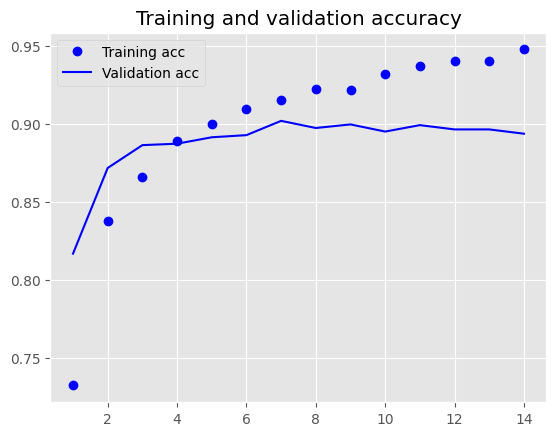

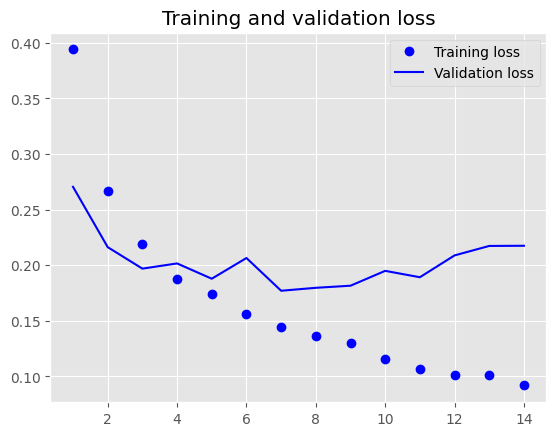

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.save('LSTM2106.h5')
print('Model LSTM has created !!!')

Model LSTM has created !!!


In [ ]:
# Melakukan test real world
input_text = """

mau jadi apa kamu kalo malas, yang rajin dunk

"""

sentiment = ['negative', 'neutral', 'positive']

text = [text_proses(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('LSTM2106.h5')
predictions = model.predict(guess)
polarity = np.argmax(predictions[0])

print("Text :", text[0])
print("Sentiment :", sentiment[polarity])

1/1 [==============================] - 0s 247ms/step
Text : mau jadi apa kamu kalau malas yang rajin dong
Sentiment : negative


## Bidirectional LSTM

In [ ]:
from tensorflow.keras.layers import Bidirectional

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Binar-Academy/data/data_bersih_update.csv')
df.drop_duplicates(subset=('pro_text_no_angka'), ignore_index=True, inplace=True)

# Fungsi untuk membagi data menjadi data train, test & validation

def train_test_val_split_imbalanced(X, y, train_percent, test_percent, val_percent, random_state=42):
    # Split the data into training and temporary set while preserving class proportions
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_percent), random_state=random_state, stratify=y)

    # Calculate the percentage of remaining data for validation and testing
    remaining_percent = 1 - train_percent
    val_percent_relative = val_percent / remaining_percent
    test_percent_relative = test_percent / remaining_percent

    # Split the temporary set into testing and validation sets while preserving class proportions
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=test_percent_relative, random_state=random_state, stratify=y_temp)

    return X_train, X_test, X_val, y_train, y_test, y_val



# Assuming 'df' is your DataFrame with 'text' and 'label' columns
X = df['pro_text_no_angka']
y = df['label']

# Split the imbalanced data into train, test, and validation sets
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split_imbalanced(X, y, 0.6, 0.2, 0.2)

# Print the sizes of the resulting sets
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))
print("Validation set size:", len(X_val))


X_train_list = X_train.to_list()
X_val_list = X_val.to_list()
X_test_list = X_test.to_list()

y_train_list = y_train.to_list()
y_val_list = y_val.to_list()
y_test_list = y_test.to_list()

max_features = 100_000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(X_train_list)

# Memanggil modul tokenizer
X_train_token = tokenizer.texts_to_sequences(X_train_list)
X_val = tokenizer.texts_to_sequences(X_val_list)
X_test = tokenizer.texts_to_sequences(X_test_list)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X_train_token)

# Memanggil modul pad sequances
X_train = pad_sequences(X_train_token,maxlen=maxlen)
X_val = pad_sequences(X_val,maxlen=maxlen)
X_test = pad_sequences(X_test,maxlen=maxlen)

Y_train_ = pd.get_dummies(y_train_list)
Y_train = Y_train_.values
y_val = pd.get_dummies(y_val_list)
y_val = y_val.values
y_test = pd.get_dummies(y_test_list)
y_test = y_test.values

embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length= maxlen))
model.add(SpatialDropout1D(0.7))
model.add(Bidirectional(LSTM(units, dropout=0.7, recurrent_dropout=0.7)))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ['accuracy'])
print(model.summary())

adam = optimizers.legacy.Adam(learning_rate=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, min_delta=0.0001,restore_best_weights=True)
history = model.fit(X_train, Y_train, epochs = 20, batch_size=128, validation_data=(X_val,y_val), verbose=1, callbacks=[es])


Train set size: 6544
Test set size: 2182
Validation set size: 2182


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          10000000  
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 100)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 10,084,867
Trainable params: 10,084,867
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
52/52 [=====================

In [ ]:
# Melakukan test real world
input_text = """

 hidup merdeka

"""

sentiment = ['negative', 'neutral', 'positive']

text = [text_proses(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X_train.shape[1])

predictions = model.predict(guess)
polarity = np.argmax(predictions[0])

print("Text :", text[0])
print("Sentiment :", sentiment[polarity])

1/1 [==============================] - 0s 117ms/step
Text : hidup merdeka
Sentiment : positive


In [ ]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

69/69 [==============================] - 4s 56ms/step - loss: 0.1801 - accuracy: 0.9051
Test set
  Loss: 0.180
  Accuracy: 0.905


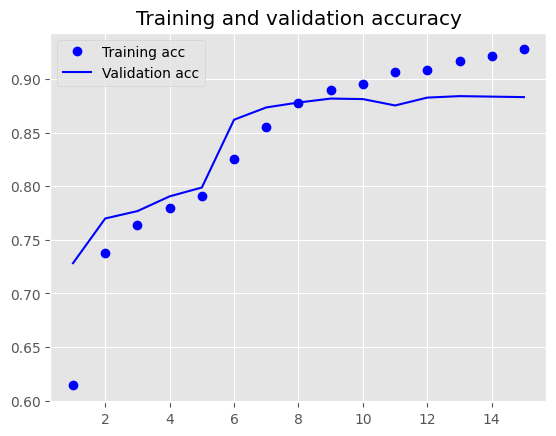

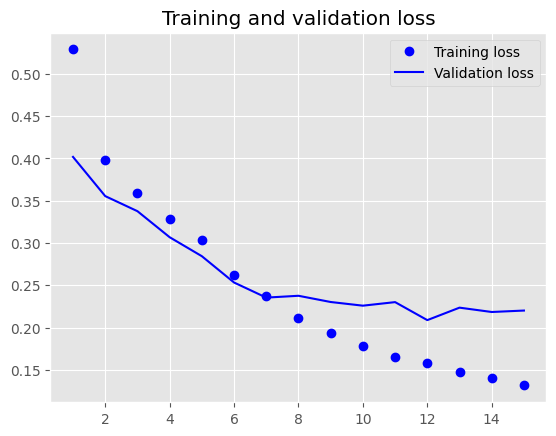

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## BertTokenizer + LSTM

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 96.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 129.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 95.7 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Binar-Academy/data/data_bersih_update.csv')
df.drop_duplicates(subset=('pro_text_no_angka'), ignore_index=True, inplace=True)

# Fungsi untuk membagi data menjadi data train, test & validation

def train_test_val_split_imbalanced(X, y, train_percent, test_percent, val_percent, random_state=42):
    # Split the data into training and temporary set while preserving class proportions
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_percent), random_state=random_state, stratify=y)

    # Calculate the percentage of remaining data for validation and testing
    remaining_percent = 1 - train_percent
    val_percent_relative = val_percent / remaining_percent
    test_percent_relative = test_percent / remaining_percent

    # Split the temporary set into testing and validation sets while preserving class proportions
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=test_percent_relative, random_state=random_state, stratify=y_temp)

    return X_train, X_test, X_val, y_train, y_test, y_val



# Assuming 'df' is your DataFrame with 'text' and 'label' columns
X = df['pro_text_no_angka']
y = df['label']

# Split the imbalanced data into train, test, and validation sets
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split_imbalanced(X, y, 0.6, 0.2, 0.2)

# Print the sizes of the resulting sets
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))
print("Validation set size:", len(X_val))

X_train_list = X_train.to_list()
X_val_list = X_val.to_list()
X_test_list = X_test.to_list()

y_train_list = y_train.to_list()
y_val_list = y_val.to_list()
y_test_list = y_test.to_list()

# max_features = 100_000
# tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
# tokenizer.fit_on_texts(X_train_list)

# # Memanggil modul tokenizer
# X_train_token = tokenizer.texts_to_sequences(X_train_list)
# X_val = tokenizer.texts_to_sequences(X_val_list)
# X_test = tokenizer.texts_to_sequences(X_test_list)

# vocab_size = len(tokenizer.word_index)
# maxlen = max(len(x) for x in X_train_token)

# # Memanggil modul pad sequances
# X_train = pad_sequences(X_train_token,maxlen=maxlen)
# X_val = pad_sequences(X_val,maxlen=maxlen)
# X_test = pad_sequences(X_test,maxlen=maxlen)

# Y_train_ = pd.get_dummies(y_train_list)
# Y_train = Y_train_.values
# y_val = pd.get_dummies(y_val_list)
# y_val = y_val.values
# y_test = pd.get_dummies(y_test_list)
# y_test = y_test.values



# BERT model setup
model_name = 'cahya/bert-base-indonesian-522M'
bert_tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = TFBertModel.from_pretrained(model_name)

# LSTM model setup
lstm_units = 128
num_classes = 3  # Number of classes for classification

# Tokenize input texts
encoded_X_train = bert_tokenizer(X_train_list, padding=True, truncation=True, return_tensors='tf')
encoded_X_val = bert_tokenizer(X_val_list, padding=True, truncation=True, return_tensors='tf')
encoded_X_test = bert_tokenizer(X_test_list, padding=True, truncation=True, return_tensors='tf')

print(encoded_X_train)

# BERT model forward pass
train_outputs = bert_model(    input_ids=encoded_X_train['input_ids'],
                               attention_mask=encoded_X_train['attention_mask'],
                               token_type_ids=encoded_X_train['token_type_ids'])
val_outputs = bert_model(encoded_X_val)
test_outputs = bert_model(encoded_X_test)

# Extract the last hidden state from the BERT outputs
train_last_hidden_state = train_outputs.last_hidden_state
val_last_hidden_state = val_outputs.last_hidden_state
test_last_hidden_state = test_outputs.last_hidden_state

# LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=lstm_units, input_shape=(train_last_hidden_state.shape[1], train_last_hidden_state.shape[2])))
lstm_model.add(Dense(units=num_classes, activation='softmax'))

# Compile the LSTM model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
print(lstm_model.summary())


Train set size: 6544
Test set size: 2182
Validation set size: 2182


Some layers from the model checkpoint at cahya/bert-base-indonesian-522M were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at cahya/bert-base-indonesian-522M.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': <tf.Tensor: shape=(6544, 92), dtype=int32, numpy=
array([[    3,  2104,  2019, ...,     2,     2,     2],
       [    3,  3946,  7164, ...,     2,     2,     2],
       [    3,  8844,  2104, ...,     2,     2,     2],
       ...,
       [    3, 11969,  1542, ...,     2,     2,     2],
       [    3,  4384, 16391, ...,     2,     2,     2],
       [    3,  6789,  3946, ...,     2,     2,     2]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(6544, 92), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(6544, 92), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32

ResourceExhaustedError: ignored

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Binar-Academy/data/data_bersih_update.csv')
df.drop_duplicates(subset=('pro_text_no_angka'), ignore_index=True, inplace=True)

# Fungsi untuk membagi data menjadi data train, test & validation

def train_test_val_split_imbalanced(X, y, train_percent, test_percent, val_percent, random_state=42):
    # Split the data into training and temporary set while preserving class proportions
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_percent), random_state=random_state, stratify=y)

    # Calculate the percentage of remaining data for validation and testing
    remaining_percent = 1 - train_percent
    val_percent_relative = val_percent / remaining_percent
    test_percent_relative = test_percent / remaining_percent

    # Split the temporary set into testing and validation sets while preserving class proportions
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=test_percent_relative, random_state=random_state, stratify=y_temp)

    return X_train, X_test, X_val, y_train, y_test, y_val



# Assuming 'df' is your DataFrame with 'text' and 'label' columns
X = df['pro_text_no_angka']
y = df['label']

# Split the imbalanced data into train, test, and validation sets
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split_imbalanced(X, y, 0.6, 0.2, 0.2)

# Print the sizes of the resulting sets
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))
print("Validation set size:", len(X_val))


X_train_list = X_train.to_list()
X_val_list = X_val.to_list()
X_test_list = X_test.to_list()

y_train_list = y_train.to_list()
y_val_list = y_val.to_list()
y_test_list = y_test.to_list()

max_features = 100_000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(X_train_list)

# Memanggil modul tokenizer
X_train_token = tokenizer.texts_to_sequences(X_train_list)
X_val = tokenizer.texts_to_sequences(X_val_list)
X_test = tokenizer.texts_to_sequences(X_test_list)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X_train_token)

# Memanggil modul pad sequances
X_train = pad_sequences(X_train_token,maxlen=maxlen)
X_val = pad_sequences(X_val,maxlen=maxlen)
X_test = pad_sequences(X_test,maxlen=maxlen)

Y_train_ = pd.get_dummies(y_train_list)
Y_train = Y_train_.values
y_val = pd.get_dummies(y_val_list)
y_val = y_val.values
y_test = pd.get_dummies(y_test_list)
y_test = y_test.values

embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length= maxlen))
model.add(SpatialDropout1D(0.7))
model.add(Bidirectional(LSTM(units, dropout=0.7, recurrent_dropout=0.7)))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics= ['accuracy'])
print(model.summary())

adam = optimizers.legacy.Adam(learning_rate=0.001)
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, min_delta=0.0001,restore_best_weights=True)
history = model.fit(X_train, Y_train, epochs = 20, batch_size=128, validation_data=(X_val,y_val), verbose=1, callbacks=[es])


In [ ]:
dir(bert_model)

['_SCALAR_UPRANKING_ON',
 '_TF_MODULE_IGNORED_PROPERTIES',
 '__annotations__',
 '__call__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_auto_class',
 '_auto_get_config',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_base_model_initialized',
 '_build_input_shape',
 '_call_spec',
 '_callable_losses',
 '_captured_weight_regularizer',
 '_cast_single_input',
 '_check_call_args',
 '_check_sample_weight_warning',
 '_checkpoi